In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import itertools
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.metrics import coverage_error
from sklearn.svm import SVC
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.neural_network import MLPClassifier
import scipy.sparse
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup

#from sklearn.preprocessing import StandardScaler

from scipy.sparse import coo_matrix, hstack


# Dataset loading

In [196]:
#Dataset loading
dataset2 = pd.read_csv('Cleaned_Posts.csv', nrows = None, index_col=0)
dataset2.shape

(49399, 10)

In [197]:
#Any np.nan ?
dataset2.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10054
PCode          9627
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [198]:
#np.nan cleaning
dataset2['TCode'] = dataset2['TCode'].fillna('None')
dataset2['PCode'] = dataset2['PCode'].fillna('None')

In [199]:
#Any np.nan ?
dataset2.isnull().sum()

TText         0
TText_NEG     0
PText         0
TCode         0
PCode         0
TTitle        0
TTitle_NEG    0
Title         0
PTags         0
Tags          0
dtype: int64

In [200]:
df = pd.DataFrame(dataset2['PTags'].tolist()).stack().value_counts()
#df = df[df>50]
df.shape

(36578,)

In [201]:
existintags = set(df.index)
existintags

{"['recursion']",
 "['javascript', 'html5', 'date']",
 "['javascript', 'browser', 'popup', 'browser-history']",
 "['mvvm', 'xamarin.forms']",
 "['jsf', 'number-formatting']",
 "['r', 'plot', 'metafor']",
 "['reactjs', 'webpack', 'redux', 'react-redux']",
 "['consul', 'nomad']",
 "['java', 'json', 'spring', 'date', 'serialization']",
 "['angularjs', 'angular1.6']",
 "['r', 'sas', 'glm']",
 "['maven', 'spring-boot']",
 "['amazon-web-services', 'amazon-cloudformation', 'serverless-framework', 'aws-batch']",
 "['datepicker', 'ngx-bootstrap']",
 "['ios', 'swift', 'uitableview', 'autoscroll']",
 "['android', 'ruby', 'rhomobile', 'rhodes']",
 "['android', 'android-fragments', 'bundle']",
 "['linux', 'gnu', 'tinymce-4', 'php-5.6']",
 "['node.js', 'laravel', 'apache', 'ssl', 'openssl']",
 "['javascript', 'google-maps-api-3', 'knockout.js']",
 "['r', 'redirect', 'sink']",
 "['php', 'sql', 'wordpress', 'woocommerce', 'custom-fields']",
 "['powershell', 'replace']",
 "['swift', 'api', 'web-service

# Dataset splitting

In [202]:
#Downsampling
dataset = dataset2.sample(10000)
dataset.shape

(10000, 10)

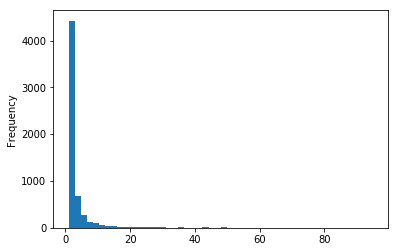

In [203]:
#Most commons tags
dataset['PTags'] = dataset['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
df = pd.DataFrame(dataset['PTags'].tolist()).stack().value_counts()
df[df<100].plot(kind = 'hist', bins = 50)
plt.show()

In [204]:
popularitytags = df[df>50].to_dict()
len(popularitytags)

68

In [205]:
#Tags cleaning
textset = dataset.copy()
textset['PTagsCleaned'] = textset['PTags'].apply(lambda x: [tag for tag in x if tag in popularitytags.keys()])
textset['PTagsCleanedLen'] = textset['PTagsCleaned'].apply(lambda x: len(x))
textset = textset[textset['PTagsCleanedLen'] != 0]
textset = textset.dropna()
print(textset.shape)
textset[['PTagsCleaned', 'PTags', 'TCode']].head()

(7929, 12)


,PTagsCleaned,PTags,TCode
Id,,,
48156097,"[javascript, jquery, html, css]","[javascript, jquery, html, css]",function showhide ( sent ){ /* Hide all elemen...
48066724,"[angular, typescript]","[angular, typescript, angular-material2]","< mat - table * ngIf ="" ! waiting "" class ="" t..."
48160123,[python-3.x],"[python-3.x, django-admin, django-autocomplete...",Uncaught TypeError : Cannot read property ' fn...
48058124,[ios],"[ios, performance, core-animation, uicollectio...",func _animateShapeLayer (_ layer : CAShapeLaye...
48123617,[php],"[php, facebook-php-sdk]",user_posts publish_pages user_photos manage_pa...


In [206]:
#X set creation
X = textset[['TText', 'TTitle', 'TCode']]

In [292]:
#Label dataset creation

y = textset['PTagsCleaned']

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(y)
Y.shape

(7929, 68)

In [293]:
#Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0, shuffle = True)

In [294]:
mlb.classes_

array(['ajax', 'amazon-web-services', 'android', 'angular', 'angularjs',
       'api', 'arrays', 'asp.net', 'asp.net-mvc', 'azure', 'bash', 'c',
       'c#', 'c++', 'css', 'database', 'django', 'docker', 'excel',
       'excel-vba', 'express', 'firebase', 'firebase-database', 'git',
       'html', 'html5', 'ios', 'java', 'javascript', 'jquery', 'json',
       'laravel', 'linux', 'mongodb', 'mysql', 'node.js', 'oracle',
       'pandas', 'php', 'postgresql', 'powershell', 'python', 'python-2.7',
       'python-3.x', 'r', 'react-native', 'reactjs', 'regex', 'rest',
       'ruby', 'ruby-on-rails', 'scala', 'selenium', 'spring',
       'spring-boot', 'sql', 'sql-server', 'swift', 'tensorflow',
       'twitter-bootstrap', 'typescript', 'vba', 'visual-studio', 'vue.js',
       'windows', 'wordpress', 'wpf', 'xml'], dtype=object)

In [295]:
mlb.transform([['r', 'ajax']])

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

# LDA version

In [298]:

class CustomLDA(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_text_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_title_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_code_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.lda_params = {'n_components':10, 'n_jobs':2, 'random_state':0, 'doc_topic_prior':None, 'topic_word_prior':None}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5}
        
        self.params = {**{'vect_text_'+k:v for k,v in self.vect_text_params.items()},
                       **{'vect_title_'+k:v for k,v in self.vect_title_params.items()},
                       **{'vect_code_'+k:v for k,v in self.vect_code_params.items()},
                       **{'lda_'+k:v for k,v in self.lda_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_()
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in customLDA.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        #Text preparation
        self.textcvect = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_text_params)
        text = self.textcvect.fit_transform(dftext)
        
        #Title preparation
        self.titlecvect = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_title_params)
        title = self.titlecvect.fit_transform(dftitle)
        
        #Code preparation
        self.codecvect = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_code_params)
        code = self.codecvect.fit_transform(dfcode)
        
        #LDA preparation
        self.lda = LatentDirichletAllocation(learning_method = 'batch', **self.lda_params)
        complete = scipy.sparse.hstack((text, title, code))
        self.lda.fit(complete)
        
        self.nametopics()
        
        return self
    
    def transformcvect(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        
        #Text preparation
        textvect = self.textcvect.transform(dftext)
        
        #Title preparation
        titlevect = self.titlecvect.transform(dftitle)
    
        #Code preparation
        codevect = self.codecvect.transform(dfcode)
        
        return scipy.sparse.hstack((textvect, titlevect, codevect))
        
    def transform(self, X, y=None):
        
        lda = self.lda.transform(self.transformcvect(X))
        return lda
    
    def get_feature_names(self):
        textfnames = self.textcvect.get_feature_names()
        titlefnames = self.titlecvect.get_feature_names()
        codefnames = self.codecvect.get_feature_names()
        toreturn = []
        toreturn.extend(textfnames)
        toreturn.extend(titlefnames)
        toreturn.extend(codefnames)
        
        return toreturn
    
    def components_(self):        
        return self.lda.components_
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_text_params = {k[10:]:v for k,v in self.params.items() if k.startswith('vect_text_')}
        self.vect_title_params = {k[11:]:v for k,v in self.params.items() if k.startswith('vect_title_')}
        self.vect_code_params = {k[10:]:v for k,v in self.params.items() if k.startswith('vect_code_')}
        
        self.lda_params = {k[4:]:v for k,v in self.params.items() if k.startswith('lda_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.lda_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def perplexity(self, X, sub_sampling=False):
        return self.lda.perplexity(self.transformcvect(X))
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_()
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self


#customLDA = CustomLDA()


In [299]:
customLDA = CustomLDA(**params)
customLDA.fit(X_test, y_test)

CustomLDA(clf_ntopics=3, clf_ntopwords=3, lda_doc_topic_prior=0.01,
     lda_n_components=100, lda_n_jobs=2, lda_random_state=0,
     lda_topic_word_prior=0.014285714285714285, vect_code_max_df=0.8,
     vect_code_max_features=15000, vect_code_min_df=5,
     vect_code_ngram_range=(1, 2), vect_text_max_df=0.9,
     vect_text_max_features=15000, vect_text_min_df=1,
     vect_text_ngram_range=(1, 2), vect_title_max_df=0.8,
     vect_title_max_features=15000, vect_title_min_df=5,
     vect_title_ngram_range=(1, 2))

In [301]:
prediction = customLDA.predict(X_test)
prediction
#customLDA.namedtopics

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [300]:
customLDA.predict_word(X_test)

array([['java', 'if', 'at java', ..., 'android', 'intent', 'java'],
       ['com', 'android', 'app', ..., 'this', 'angular', 'scope'],
       ['log', 'console', 'console log', ..., 'this', 'props', 'state'],
       ..., 
       ['column', 'column', 'me', ..., 'the', 'err', 'error'],
       ['info', 'org', 'main', ..., 'work', 'page', 'use'],
       ['this', 'props', 'state', ..., 'public', 'string', 'get']],
      dtype='<U17')

In [297]:
y_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Some docs about the parameters : https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [303]:
topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 3,
 'lda_n_components': topic,
 'lda_n_jobs': 2,
 'lda_random_state': 0,
 'lda_doc_topic_prior': 0.01,
 'lda_topic_word_prior': 0.014285714285714285,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 5,
 'vect_code_ngram_range': (1, 2),
 'vect_text_max_df': 0.9,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 1,
 'vect_text_ngram_range': (1, 2),
 'vect_title_max_df': 0.9,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 2)}

customLDA = CustomLDA(**params)
customLDA.fit(X_train, y_train)

CustomLDA(clf_ntopics=3, clf_ntopwords=3, lda_doc_topic_prior=0.01,
     lda_n_components=100, lda_n_jobs=2, lda_random_state=0,
     lda_topic_word_prior=0.014285714285714285, vect_code_max_df=0.8,
     vect_code_max_features=15000, vect_code_min_df=5,
     vect_code_ngram_range=(1, 2), vect_text_max_df=0.9,
     vect_text_max_features=15000, vect_text_min_df=1,
     vect_text_ngram_range=(1, 2), vect_title_max_df=0.9,
     vect_title_max_features=5000, vect_title_min_df=1,
     vect_title_ngram_range=(1, 2))

In [304]:
#[1/len(x) if len(x) !=0 else 0 for x in customLDA.topicsnamed.values()]
customLDA.score()

8.5

In [305]:
#Perplexity
customLDA.perplexity(X_test)

14797.456286072096

# TSNE reduction dimension

In [306]:
X_lda = customLDA.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_lda)

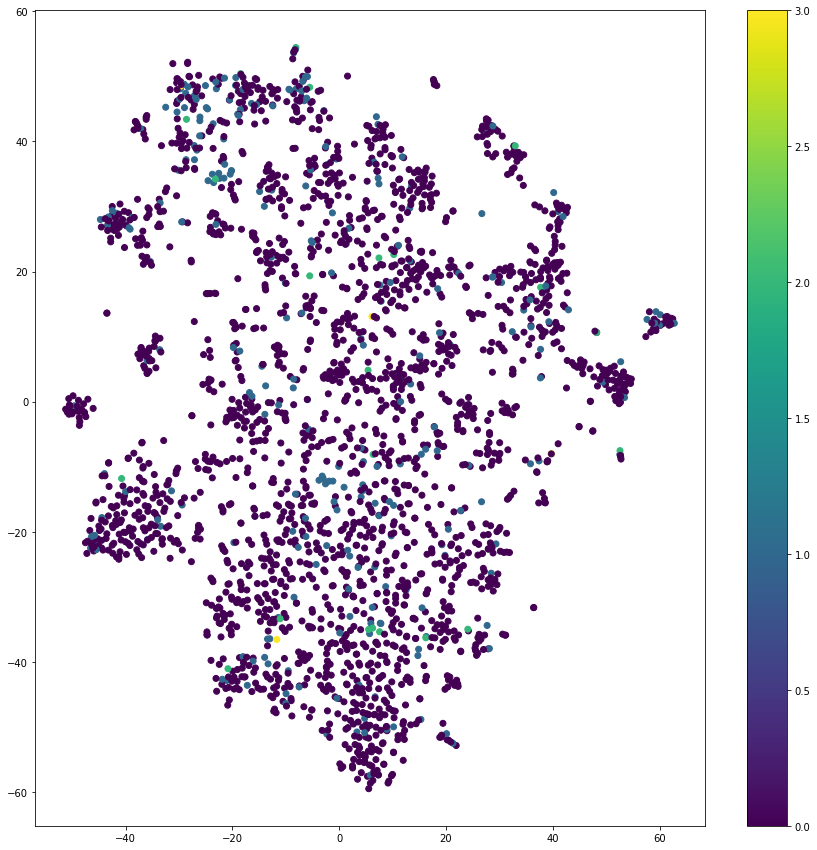

In [307]:
# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(customLDA.transform(X_test), 0)[:, 0]
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

In [154]:
#gridsearch to optimize the parameters - TEXT - STEP 1

topic = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 3,
 'lda_n_components': topic,
 'lda_n_jobs': 2,
 'lda_random_state': 0,
 'lda_doc_topic_prior': 0.01,
 'lda_topic_word_prior': 0.014285714285714285,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 5,
 'vect_code_ngram_range': (1, 2),
 'vect_text_max_df': 0.9,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 1,
 'vect_text_ngram_range': (1, 2),
 'vect_title_max_df': 0.9,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 2)}

customLDA = CustomLDA(**params)

parameters = {'vect_text_min_df': [1, 10], 'vect_text_max_df': [0.9,1.], 'vect_text_max_features': [15000, 20000], 'vect_text_ngram_range': [(1,2), (1,2)],}
#parameters = {'lda_doc_topic_prior':[ 1/(topic*1.3), 1/(topic), 1/(topic*0.7)], 'lda_topic_word_prior':[ 1/(topic*1.3), 1/(topic), 1/(topic*0.7)]}


clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3)
clf.fit(X_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=1, vect_text_ngram_range=(1, 2) 
[CV]  vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=1, vect_text_ngram_range=(1, 2), score=63.83333333333333, total=  30.0s
[CV] vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=1, vect_text_ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.1s remaining:    0.0s


[CV]  vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=1, vect_text_ngram_range=(1, 2), score=60.33333333333333, total=  30.4s
[CV] vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=1, vect_text_ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV]  vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=1, vect_text_ngram_range=(1, 2), score=63.83333333333333, total=  29.8s
[CV] vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=1, vect_text_ngram_range=(1, 2) 
[CV]  vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=1, vect_text_ngram_range=(1, 2), score=60.33333333333333, total=  29.9s
[CV] vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=10, vect_text_ngram_range=(1, 2) 
[CV]  vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=10, vect_text_ngram_range=(1, 2), score=60.83333333333333, total=  21.0s
[CV] vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=10, vect_text_ngram_range=(1, 2) 
[CV]  vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=10, vect_text_ngram_range=(1, 2), score=60.16666666666667, total=  20.5s
[CV] vect_text_max_df=0.9, vect_text_max_features=15000, vect_text_min_df=10, vect_text

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 13.5min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_ntopics=3, clf_ntopwords=3, lda_doc_topic_prior=0.01,
     lda_n_components=100, lda_n_jobs=2, lda_random_state=0,
     lda_topic_word_prior=0.014285714285714285, vect_code_max_df=0.8,
     vect_code_max_features=15000, vect_code_min_df=5,
     vect_code_ngram_range=(1, 2), v...df=0.8,
     vect_title_max_features=15000, vect_title_min_df=5,
     vect_title_ngram_range=(1, 2)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect_text_min_df': [1, 10], 'vect_text_max_df': [0.9, 1.0], 'vect_text_max_features': [15000, 20000], 'vect_text_ngram_range': [(1, 2), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [155]:
clf.best_params_

{'vect_text_max_df': 0.9,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 1,
 'vect_text_ngram_range': (1, 2)}

In [156]:
clf.best_score_

62.083333333333329

In [157]:
#gridsearch to optimize the parameters  - TITLE - STEP 2

topic = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 3,
 'lda_n_components': topic,
 'lda_n_jobs': 2,
 'lda_random_state': 0,
 'lda_doc_topic_prior': 0.01,
 'lda_topic_word_prior': 0.014285714285714285,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 5,
 'vect_code_ngram_range': (1, 2),
 'vect_text_max_df': 0.9,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 1,
 'vect_text_ngram_range': (1, 2),
 'vect_title_max_df': 0.9,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 2)}

customLDA = CustomLDA(**params)

parameters = {'vect_title_min_df': [1, 10], 'vect_title_max_df': [0.9,1.], 'vect_title_max_features': [5000, 7000, 9000], 'vect_title_ngram_range': [(1,3), (1,2)],}
#parameters = {'lda_doc_topic_prior':[ 1/(topic*1.3), 1/(topic), 1/(topic*0.7)], 'lda_topic_word_prior':[ 1/(topic*1.3), 1/(topic), 1/(topic*0.7)]}


clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3)
clf.fit(X_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 3) 
[CV]  vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 3), score=63.83333333333333, total=  31.0s
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 3) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.0s remaining:    0.0s


[CV]  vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 3), score=56.49999999999999, total=  31.1s
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV]  vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 2), score=67.5, total=  31.1s
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 2) 
[CV]  vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=1, vect_title_ngram_range=(1, 2), score=58.666666666666664, total=  31.6s
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=10, vect_title_ngram_range=(1, 3) 
[CV]  vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=10, vect_title_ngram_range=(1, 3), score=60.66666666666667, total=  28.1s
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=10, vect_title_ngram_range=(1, 3) 
[CV]  vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=10, vect_title_ngram_range=(1, 3), score=61.83333333333334, total=  28.0s
[CV] vect_title_max_df=0.9, vect_title_max_features=5000, vect_title_min_df=10

[CV]  vect_title_max_df=1.0, vect_title_max_features=7000, vect_title_min_df=1, vect_title_ngram_range=(1, 2), score=55.83333333333332, total=  32.8s
[CV] vect_title_max_df=1.0, vect_title_max_features=7000, vect_title_min_df=1, vect_title_ngram_range=(1, 2) 
[CV]  vect_title_max_df=1.0, vect_title_max_features=7000, vect_title_min_df=1, vect_title_ngram_range=(1, 2), score=58.83333333333333, total=  33.4s
[CV] vect_title_max_df=1.0, vect_title_max_features=7000, vect_title_min_df=10, vect_title_ngram_range=(1, 3) 
[CV]  vect_title_max_df=1.0, vect_title_max_features=7000, vect_title_min_df=10, vect_title_ngram_range=(1, 3), score=60.66666666666667, total=  28.3s
[CV] vect_title_max_df=1.0, vect_title_max_features=7000, vect_title_min_df=10, vect_title_ngram_range=(1, 3) 
[CV]  vect_title_max_df=1.0, vect_title_max_features=7000, vect_title_min_df=10, vect_title_ngram_range=(1, 3), score=61.83333333333334, total=  29.0s
[CV] vect_title_max_df=1.0, vect_title_max_features=7000, vect_tit

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 24.5min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_ntopics=3, clf_ntopwords=3, lda_doc_topic_prior=0.01,
     lda_n_components=100, lda_n_jobs=2, lda_random_state=0,
     lda_topic_word_prior=0.014285714285714285, vect_code_max_df=0.8,
     vect_code_max_features=15000, vect_code_min_df=5,
     vect_code_ngram_range=(1, 2), v...df=0.8,
     vect_title_max_features=15000, vect_title_min_df=5,
     vect_title_ngram_range=(1, 2)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect_title_min_df': [1, 10], 'vect_title_max_df': [0.9, 1.0], 'vect_title_max_features': [5000, 7000, 9000], 'vect_title_ngram_range': [(1, 3), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [158]:
clf.best_params_

{'vect_title_max_df': 0.9,
 'vect_title_max_features': 5000,
 'vect_title_min_df': 1,
 'vect_title_ngram_range': (1, 2)}

In [159]:
clf.best_score_

63.083333333333329

In [ ]:
dataset.head(10)

In [ ]:
article = [48168060, 48150752]
samplepost = dataset[['TText', 'TTitle', 'TCode']].loc[article]
print(dataset["PTags"].loc[article])
np.array(clf.predict(samplepost))

In [ ]:
dataset[['TText', 'TTitle', 'TCode', 'PTags']]

# NMF version

In [ ]:

class CustomNMF(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_text_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_title_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_code_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.nmf_params = {'n_components':10, 'random_state':0, 'init':'nndsvd', 'alpha':0, 'l1_ratio':0}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5}
        
        self.params = {**{'vect_text_'+k:v for k,v in self.vect_text_params.items()},
                       **{'vect_title_'+k:v for k,v in self.vect_title_params.items()},
                       **{'vect_code_'+k:v for k,v in self.vect_code_params.items()},
                       **{'nmf_'+k:v for k,v in self.nmf_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict(self, X, y=None):
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_()
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.append(tags)
            toreturn.append(docprediction)
        return toreturn
    
    def fit(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        #Text preparation
        self.textcvect = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_text_params)
        text = self.textcvect.fit_transform(dftext)
        
        #Title preparation
        self.titlecvect = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_title_params)
        title = self.titlecvect.fit_transform(dftitle)
        
        #Code preparation
        self.codecvect = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_code_params)
        code = self.codecvect.fit_transform(dfcode)
        
        #LDA preparation
        self.nmf = NMF(**self.nmf_params)
        complete = scipy.sparse.hstack((text, title, code))
        self.nmf.fit(complete)
        
        return self
    
    def transform(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        
        #Text preparation
        textvect = self.textcvect.transform(dftext)
        
        #Title preparation
        titlevect = self.titlecvect.transform(dftitle)
    
        #Code preparation
        codevect = self.codecvect.transform(dfcode)
        
        nmf = self.nmf.transform(scipy.sparse.hstack((textvect, titlevect, codevect)))
        
        return nmf
    
    def get_feature_names(self):
        textfnames = self.textcvect.get_feature_names()
        titlefnames = self.titlecvect.get_feature_names()
        codefnames = self.codecvect.get_feature_names()
        toreturn = []
        toreturn.extend(textfnames)
        toreturn.extend(titlefnames)
        toreturn.extend(codefnames)
        
        return toreturn
    
    def components_(self):        
        return self.nmf.components_
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_text_params = {k[10:]:v for k,v in self.params.items() if k.startswith('vect_text_')}
        self.vect_title_params = {k[11:]:v for k,v in self.params.items() if k.startswith('vect_title_')}
        self.vect_code_params = {k[10:]:v for k,v in self.params.items() if k.startswith('vect_code_')}
        
        self.nmf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('nmf_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.nmf_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_()
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in existintags]
            for tag in tags:
                if tag in existintags:
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self


customNMF = CustomNMF()


In [ ]:
params = {'clf_ntopics': 3,
 'clf_ntopwords': 3,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_code_max_df': 0.8,
 'vect_code_max_features': 15000,
 'vect_code_min_df': 5,
 'vect_code_ngram_range': (1, 2),
 'vect_text_max_df': 0.8,
 'vect_text_max_features': 15000,
 'vect_text_min_df': 10,
 'vect_text_ngram_range': (1, 3),
 'vect_title_max_df': 0.8,
 'vect_title_max_features': 15000,
 'vect_title_min_df': 5,
 'vect_title_ngram_range': (1, 2)}

customNMF = CustomNMF(**params)
customNMF.fit(dataset[['TText', 'TTitle', 'TCode']])

In [ ]:
customNMF.score()
#customNMF.namedtopics

In [ ]:
article = [48168060, 48150752]
samplepost = dataset[['TText', 'TTitle', 'TCode']].loc[article]
print(dataset["PTags"].loc[article])
np.array(customNMF.predict(samplepost))

In [ ]:
customNMF.set_params(clf_ntopwords=5)